In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [7]:
import numpy as np
import pandas as pd

# CSV 파일의 컬럼 이름 지정 (첫 번째 컬럼은 버릴 값이므로 "NaN"으로 명명)
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]

# CSV 파일 읽기 (header 없이, 첫 줄은 skip)
data = pd.read_csv("/Users/ohheungchan/workspace/AI_Study/paperwork/WISDM.csv",
                   header=None, names=names, skiprows=1)

# "NaN" 컬럼 제거
df = data.drop('NaN', axis=1)

# 'z_axis' 컬럼을 문자열로 변환 후 세미콜론(;) 제거
df["z_axis"] = df["z_axis"].astype(str).str.replace(';', '', regex=True)

# 문자열 데이터를 float으로 변환 (에러 발생 시 NaN으로 처리)
df["timestamp"] = pd.to_numeric(df["timestamp"], errors='coerce')
df["x_axis"]    = pd.to_numeric(df["x_axis"], errors='coerce')
df["y_axis"]    = pd.to_numeric(df["y_axis"], errors='coerce')
df["z_axis"]    = pd.to_numeric(df["z_axis"], errors='coerce')

# 결측치가 있는 행 제거
df.dropna(axis=0, how='any', inplace=True)

# 결과 확인
print(df.head())
print("DataFrame shape:", df.shape)

   user_id activity       timestamp    x_axis     y_axis    z_axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164
DataFrame shape: (1098203, 6)


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (878562, 6)
Test set shape: (219641, 6)


In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder  # CrossEntropyLoss는 정수형 라벨을 사용하므로 OneHot은 필요없음

#############################################
# 1. 데이터 전처리 및 레이블 인코딩
#############################################
# df는 이미 'x_axis', 'y_axis', 'z_axis', 'activity' 컬럼을 가진 DataFrame이라고 가정합니다.
le = LabelEncoder()
train_df['ActivityEncoded'] = le.fit_transform(train_df['activity'])
num_classes = len(le.classes_)
print("활동 클래스:", le.classes_)


활동 클래스: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [12]:
train_df.activity.value_counts()

activity
Walking       339355
Jogging       273612
Upstairs       98288
Downstairs     80464
Sitting        48071
Standing       38772
Name: count, dtype: int64

<Axes: xlabel='activity', ylabel='count'>

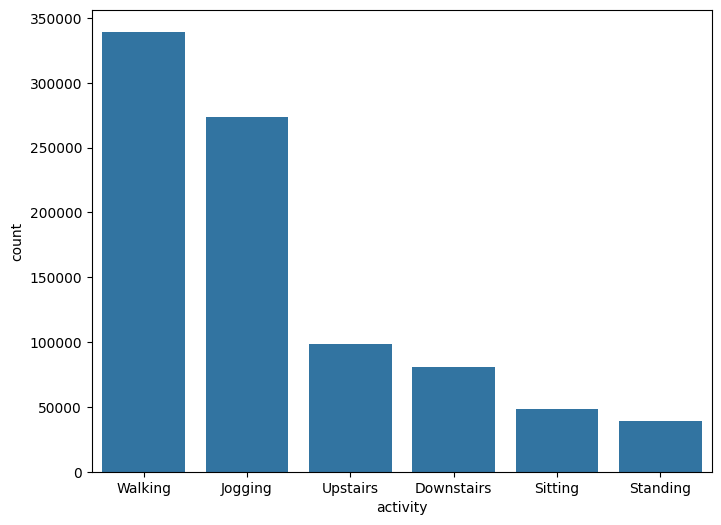

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "activity", data = train_df, order = train_df.activity.value_counts().index)
     

In [14]:
#############################################
# 2. Diffusion 모델 관련 함수 정의
#############################################
# UNet1D: Conv1D 기반 모델
class UNet1D(nn.Module):
    def __init__(self, input_dim=3):
        super(UNet1D, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, input_dim, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

def forward_diffusion(x, timesteps, beta_schedule):
    noise_levels = np.cumprod(1 - beta_schedule)
    x_noisy = []
    for t in range(timesteps):
        # noise에 대해 명시적으로 dtype을 float32로 설정
        noise = torch.randn_like(x) * torch.sqrt(torch.tensor(beta_schedule[t], dtype=torch.float32))
        noisy_x = torch.sqrt(torch.tensor(noise_levels[t], dtype=torch.float32)) * x + noise
        x_noisy.append(noisy_x)
    return x_noisy

def train_diffusion_model(sensor_data, epochs=500, lr=0.001, timesteps=10):
    # Apple Silicon GPU (MPS) 우선, 그 외 cuda 또는 cpu 사용
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Diffusion 모델 학습 시 사용 device: {device}")
    
    model = UNet1D(input_dim=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # sensor_data: (N, 3) → (N, 3, 1)
    sensor_data = torch.tensor(sensor_data, dtype=torch.float32).unsqueeze(-1).to(device)
    beta_schedule = np.linspace(0.0001, 0.02, timesteps)
    for epoch in tqdm(range(epochs), desc='Training Diffusion Model'):
        optimizer.zero_grad()
        idx = torch.randint(0, sensor_data.shape[0], (32,))
        x = sensor_data[idx]
        x_noisy_steps = forward_diffusion(x, timesteps, beta_schedule)
        t = torch.randint(0, timesteps, (1,)).item()
        noisy_x = x_noisy_steps[t]
        predicted_x = model(noisy_x, t)
        loss = criterion(predicted_x, x)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}')
    return model

def generate_synthetic_data(model, num_samples=100, timesteps=10):
    # Apple Silicon GPU (MPS) 우선, 그 외 cuda 또는 cpu 사용
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"합성 데이터 생성 시 사용 device: {device}")
    
    model.to(device)
    model.eval()
    beta_schedule = np.linspace(0.0001, 0.02, timesteps)
    noise_levels = np.cumprod(1 - beta_schedule)
    with torch.no_grad():
        # 초기 노이즈 샘플 (합성 데이터 시작점)
        synthetic_data = torch.randn((num_samples, 3, 1), dtype=torch.float32).to(device)
        for t in reversed(range(timesteps)):
            predicted_x = model(synthetic_data, t)
            noise = torch.randn_like(predicted_x) * torch.sqrt(torch.tensor(beta_schedule[t], dtype=torch.float32))
            synthetic_data = (predicted_x - noise) / torch.sqrt(torch.tensor(noise_levels[t], dtype=torch.float32))
    # 마지막 차원 제거: (num_samples, 3, 1) → (num_samples, 3)
    return synthetic_data.squeeze(-1).cpu().numpy()

def prepare_loader(X, y, batch_size=64):
    # CNN 모델 입력은 (N, 3) → unsqueeze(-1) → (N, 3, 1)
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

#############################################
# 3. 트레인셋 클래스별 밸런싱 (Diffusion을 이용한 증강)
#############################################
# 각 클래스별 원본 샘플 수 확인
class_counts = train_df['activity'].value_counts()
max_count = class_counts.max()
print("최대 샘플 수:", max_count)

augmented_dfs = []

# le.classes_에 포함된 각 클래스에 대해
for cls in le.classes_:
    df_cls = train_df[train_df['activity'] == cls].copy()
    count = df_cls.shape[0]
    print(f"클래스 '{cls}'의 원본 샘플 수: {count}")
    
    # 부족한 샘플 수(diff) 계산
    if count < max_count:
        diff = max_count - count
        print(f"클래스 '{cls}'의 부족한 샘플 수: {diff}")
        # 센서 데이터 추출 (열: 'x_axis', 'y_axis', 'z_axis')
        sensor_data = df_cls[['x_axis', 'y_axis', 'z_axis']].values
        # 해당 클래스에 대해 Diffusion 모델 학습 (증강 품질에 따라 epochs, timesteps 조정)
        diffusion_model = train_diffusion_model(sensor_data, epochs=500, lr=0.001, timesteps=10)
        # 부족한 개수만큼 합성 데이터 생성
        synthetic_data = generate_synthetic_data(diffusion_model, num_samples=diff, timesteps=10)
        # 합성 데이터를 DataFrame으로 변환
        df_synth = pd.DataFrame(synthetic_data, columns=['x_axis', 'y_axis', 'z_axis'])
        df_synth['activity'] = cls
        df_synth['activity_encoded'] = le.transform([cls])[0]
        # 원본 데이터와 합성 데이터를 결합
        df_cls = pd.concat([df_cls, df_synth], axis=0)
    else:
        print(f"클래스 '{cls}'는 이미 충분한 샘플 수 보유")
    
    augmented_dfs.append(df_cls)

# 모든 클래스 데이터를 합쳐 밸런스된 트레인셋 구성
df_train_balanced = pd.concat(augmented_dfs, axis=0).reset_index(drop=True)
print("밸런스된 트레인셋 shape:", df_train_balanced.shape)
print("밸런스된 트레인셋 클래스별 샘플 수:\n", df_train_balanced['activity'].value_counts())

최대 샘플 수: 339355
클래스 'Downstairs'의 원본 샘플 수: 80464
클래스 'Downstairs'의 부족한 샘플 수: 258891
Diffusion 모델 학습 시 사용 device: mps


Training Diffusion Model:  10%|█▌              | 49/500 [00:02<00:12, 37.37it/s]

Epoch [0/500], Loss: 46.806038


Training Diffusion Model:  30%|████▏         | 151/500 [00:02<00:02, 141.35it/s]

Epoch [100/500], Loss: 3.843697


Training Diffusion Model:  46%|██████▍       | 231/500 [00:02<00:01, 209.22it/s]

Epoch [200/500], Loss: 0.072271


Training Diffusion Model:  68%|█████████▌    | 340/500 [00:03<00:00, 251.67it/s]

Epoch [300/500], Loss: 0.073078


Training Diffusion Model:  90%|████████████▌ | 449/500 [00:03<00:00, 261.61it/s]

Epoch [400/500], Loss: 0.266127



raining Diffusion Model: 100%|██████████████| 500/500 [00:03<00:00, 129.61it/s]

합성 데이터 생성 시 사용 device: mps
클래스 'Jogging'의 원본 샘플 수: 273612
클래스 'Jogging'의 부족한 샘플 수: 65743
Diffusion 모델 학습 시 사용 device: mps


Training Diffusion Model:   5%|▋              | 24/500 [00:00<00:02, 233.70it/s]

Epoch [0/500], Loss: 75.256393


Training Diffusion Model:  26%|███▌          | 129/500 [00:00<00:01, 257.47it/s]

Epoch [100/500], Loss: 0.717531


Training Diffusion Model:  47%|██████▋       | 237/500 [00:00<00:00, 263.50it/s]

Epoch [200/500], Loss: 0.135299


Training Diffusion Model:  69%|█████████▋    | 345/500 [00:01<00:00, 257.68it/s]

Epoch [300/500], Loss: 0.126559


Training Diffusion Model:  90%|████████████▌ | 449/500 [00:01<00:00, 252.85it/s]

Epoch [400/500], Loss: 0.265010



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 254.13it/s]

합성 데이터 생성 시 사용 device: mps
클래스 'Sitting'의 원본 샘플 수: 48071
클래스 'Sitting'의 부족한 샘플 수: 291284
Diffusion 모델 학습 시 사용 device: mps


Training Diffusion Model:   5%|▊              | 26/500 [00:00<00:01, 255.39it/s]

Epoch [0/500], Loss: 32.262268


Training Diffusion Model:  26%|███▋          | 132/500 [00:00<00:01, 262.73it/s]

Epoch [100/500], Loss: 0.992179


Training Diffusion Model:  48%|██████▋       | 240/500 [00:00<00:00, 260.25it/s]

Epoch [200/500], Loss: 0.052589


Training Diffusion Model:  70%|█████████▊    | 349/500 [00:01<00:00, 262.62it/s]

Epoch [300/500], Loss: 0.021531


Training Diffusion Model:  86%|████████████  | 429/500 [00:01<00:00, 262.25it/s]

Epoch [400/500], Loss: 0.045092



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 259.00it/s]

합성 데이터 생성 시 사용 device: mps
클래스 'Standing'의 원본 샘플 수: 38772
클래스 'Standing'의 부족한 샘플 수: 300583
Diffusion 모델 학습 시 사용 device: mps


Training Diffusion Model:   5%|▋              | 23/500 [00:00<00:02, 229.85it/s]

Epoch [0/500], Loss: 31.821224


Training Diffusion Model:  31%|████▎         | 154/500 [00:00<00:01, 257.90it/s]

Epoch [100/500], Loss: 1.408398


Training Diffusion Model:  47%|██████▌       | 233/500 [00:00<00:01, 260.45it/s]

Epoch [200/500], Loss: 0.336586


Training Diffusion Model:  68%|█████████▌    | 342/500 [00:01<00:00, 258.09it/s]

Epoch [300/500], Loss: 0.237393


Training Diffusion Model:  90%|████████████▌ | 448/500 [00:01<00:00, 252.47it/s]

Epoch [400/500], Loss: 0.033129



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 251.62it/s]

합성 데이터 생성 시 사용 device: mps
클래스 'Upstairs'의 원본 샘플 수: 98288
클래스 'Upstairs'의 부족한 샘플 수: 241067
Diffusion 모델 학습 시 사용 device: mps


Training Diffusion Model:   5%|▊              | 25/500 [00:00<00:01, 245.54it/s]

Epoch [0/500], Loss: 38.725109


Training Diffusion Model:  26%|███▋          | 130/500 [00:00<00:01, 260.31it/s]

Epoch [100/500], Loss: 4.339497


Training Diffusion Model:  48%|██████▋       | 239/500 [00:00<00:00, 266.19it/s]

Epoch [200/500], Loss: 0.072910


Training Diffusion Model:  69%|█████████▋    | 347/500 [00:01<00:00, 253.53it/s]

Epoch [300/500], Loss: 0.080541


Training Diffusion Model:  91%|████████████▋ | 454/500 [00:01<00:00, 260.80it/s]

Epoch [400/500], Loss: 0.154104



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 258.50it/s]

합성 데이터 생성 시 사용 device: mps
클래스 'Walking'의 원본 샘플 수: 339355
클래스 'Walking'는 이미 충분한 샘플 수 보유
밸런스된 트레인셋 shape: (2036130, 8)
밸런스된 트레인셋 클래스별 샘플 수:
 activity
Downstairs    339355
Jogging       339355
Sitting       339355
Standing      339355
Upstairs      339355
Walking       339355
Name: count, dtype: int64


In [19]:

#############################################
# 1. 레이블 인코딩
#############################################
le = LabelEncoder()
df_train_balanced['activity_encoded'] = le.fit_transform(df_train_balanced['activity'])
num_classes = len(le.classes_)
print("활동 클래스:", le.classes_)
print("원본 클래스별 샘플 수:\n", df_train_balanced['activity_encoded'].value_counts())


활동 클래스: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
원본 클래스별 샘플 수:
 activity_encoded
0    339355
1    339355
2    339355
3    339355
4    339355
5    339355
Name: count, dtype: int64


<Axes: xlabel='activity', ylabel='count'>

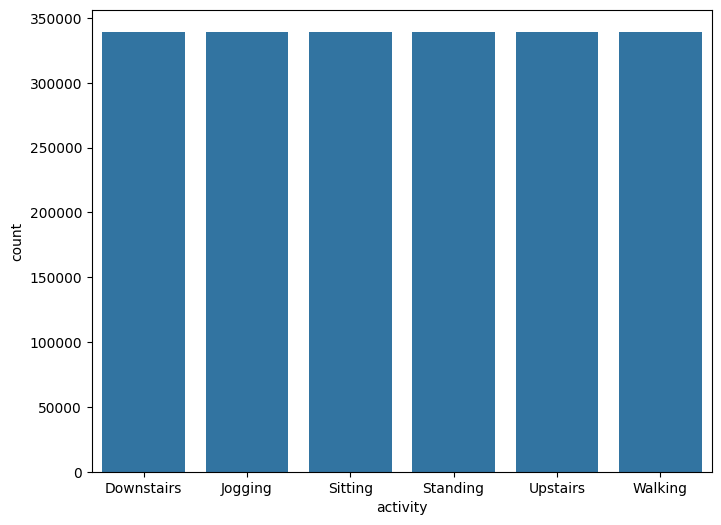

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "activity", data = df_train_balanced, order = df_train_balanced.activity.value_counts().index)
     

In [10]:

#############################################
# 3. 트레인셋 클래스별 밸런싱 (Diffusion을 이용한 증강)
#############################################
# 각 클래스별 원본 샘플 수 확인
class_counts = df['activity'].value_counts()
max_count = class_counts.max()
print("최대 샘플 수:", max_count)

augmented_dfs = []
for cls in le.classes_:
    df_cls = df[df['activity'] == cls].copy()
    count = df_cls.shape[0]
    print(f"클래스 {cls}의 원본 샘플 수: {count}")
    if count < max_count:
        diff = max_count - count
        print(f"클래스 {cls}의 부족한 샘플 수: {diff}")
        # 센서 데이터 추출 (열 이름 변경: 'x_axis', 'y_axis', 'z_axis')
        sensor_data = df_cls[['x_axis', 'y_axis', 'z_axis']].values
        # Diffusion 모델 학습 (여기서는 증강 품질에 따라 epochs=500, timesteps=10 사용)
        diffusion_model = train_diffusion_model(sensor_data, epochs=500, lr=0.001, timesteps=10)
        # 부족한 개수만큼 합성 데이터 생성
        synthetic_data = generate_synthetic_data(diffusion_model, num_samples=diff, timesteps=10)
        # 합성 데이터를 DataFrame으로 변환
        df_synth = pd.DataFrame(synthetic_data, columns=['x_axis', 'y_axis', 'z_axis'])
        df_synth['activity'] = cls
        df_synth['activity_encoded'] = le.transform([cls])[0]
        # 원본 데이터와 합성 데이터를 결합
        df_cls = pd.concat([df_cls, df_synth], axis=0)
    else:
        print(f"클래스 {cls}는 이미 충분한 샘플 수 보유")
    augmented_dfs.append(df_cls)

df_train_balanced = pd.concat(augmented_dfs, axis=0).reset_index(drop=True)
print("밸런스된 트레인셋 shape:", df_train_balanced.shape)
print("밸런스된 트레인셋 클래스별 샘플 수:\n", df_train_balanced['activity'].value_counts())


최대 샘플 수: 424397
클래스 Downstairs의 원본 샘플 수: 100427
클래스 Downstairs의 부족한 샘플 수: 323970


Training Diffusion Model:   5%|▊               | 27/500 [00:00<00:05, 89.87it/s]

Epoch [0/500], Loss: 46.063290


Training Diffusion Model:  27%|███▋          | 133/500 [00:00<00:01, 222.37it/s]

Epoch [100/500], Loss: 0.338068


Training Diffusion Model:  48%|██████▋       | 238/500 [00:01<00:01, 250.39it/s]

Epoch [200/500], Loss: 0.022754


Training Diffusion Model:  69%|█████████▋    | 345/500 [00:01<00:00, 260.92it/s]

Epoch [300/500], Loss: 0.054647


Training Diffusion Model:  90%|████████████▋ | 452/500 [00:02<00:00, 260.66it/s]

Epoch [400/500], Loss: 0.103797



raining Diffusion Model: 100%|██████████████| 500/500 [00:02<00:00, 226.80it/s]

클래스 Jogging의 원본 샘플 수: 342176
클래스 Jogging의 부족한 샘플 수: 82221


Training Diffusion Model:   5%|▊              | 25/500 [00:00<00:01, 249.23it/s]

Epoch [0/500], Loss: 58.317665


Training Diffusion Model:  26%|███▋          | 131/500 [00:00<00:01, 256.11it/s]

Epoch [100/500], Loss: 1.012912


Training Diffusion Model:  48%|██████▋       | 238/500 [00:00<00:01, 260.52it/s]

Epoch [200/500], Loss: 0.052426


Training Diffusion Model:  69%|█████████▋    | 346/500 [00:01<00:00, 255.59it/s]

Epoch [300/500], Loss: 0.060811


Training Diffusion Model:  85%|███████████▉  | 427/500 [00:01<00:00, 260.52it/s]

Epoch [400/500], Loss: 0.089985



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 258.96it/s]

클래스 Sitting의 원본 샘플 수: 59939
클래스 Sitting의 부족한 샘플 수: 364458


Training Diffusion Model:   5%|▊              | 25/500 [00:00<00:01, 242.15it/s]

Epoch [0/500], Loss: 33.433434


Training Diffusion Model:  25%|███▌          | 127/500 [00:00<00:01, 234.83it/s]

Epoch [100/500], Loss: 0.343496


Training Diffusion Model:  47%|██████▌       | 234/500 [00:00<00:01, 255.76it/s]

Epoch [200/500], Loss: 0.057874


Training Diffusion Model:  68%|█████████▌    | 341/500 [00:01<00:00, 257.42it/s]

Epoch [300/500], Loss: 0.057944


Training Diffusion Model:  89%|████████████▌ | 447/500 [00:01<00:00, 259.65it/s]

Epoch [400/500], Loss: 0.041039



raining Diffusion Model: 100%|██████████████| 500/500 [00:01<00:00, 250.23it/s]

클래스 Standing의 원본 샘플 수: 48395
클래스 Standing의 부족한 샘플 수: 376002


Training Diffusion Model:   5%|▊              | 26/500 [00:00<00:01, 254.18it/s]

Epoch [0/500], Loss: 32.320961


Training Diffusion Model:  27%|███▋          | 133/500 [00:00<00:01, 264.28it/s]

Epoch [100/500], Loss: 4.304397


Training Diffusion Model:  47%|██████▌       | 236/500 [00:00<00:01, 231.34it/s]

Epoch [200/500], Loss: 0.545741


Training Diffusion Model:  67%|█████████▎    | 334/500 [00:01<00:00, 224.96it/s]

Epoch [300/500], Loss: 0.177848


Training Diffusion Model:  87%|████████████▏ | 436/500 [00:01<00:00, 241.19it/s]

Epoch [400/500], Loss: 0.042174



raining Diffusion Model: 100%|██████████████| 500/500 [00:02<00:00, 241.76it/s]

클래스 Upstairs의 원본 샘플 수: 122869
클래스 Upstairs의 부족한 샘플 수: 301528


Training Diffusion Model:   4%|▌              | 19/500 [00:00<00:02, 188.59it/s]

Epoch [0/500], Loss: 43.160767


Training Diffusion Model:  30%|████▏         | 149/500 [00:00<00:01, 252.75it/s]

Epoch [100/500], Loss: 0.512888


Training Diffusion Model:  45%|██████▎       | 227/500 [00:00<00:01, 256.82it/s]

Epoch [200/500], Loss: 0.066156


Training Diffusion Model:  66%|█████████▎    | 331/500 [00:01<00:00, 242.31it/s]

Epoch [300/500], Loss: 0.073910


Training Diffusion Model:  87%|████████████▏ | 436/500 [00:01<00:00, 247.99it/s]

Epoch [400/500], Loss: 0.154101



raining Diffusion Model: 100%|██████████████| 500/500 [00:02<00:00, 242.63it/s]

클래스 Walking의 원본 샘플 수: 424397
클래스 Walking는 이미 충분한 샘플 수 보유
밸런스된 트레인셋 shape: (2546382, 8)
밸런스된 트레인셋 클래스별 샘플 수:
 activity
Downstairs    424397
Jogging       424397
Sitting       424397
Standing      424397
Upstairs      424397
Walking       424397
Name: count, dtype: int64


In [23]:
#############################################
# 2. 시계열 데이터 세그먼테이션 함수 정의
#############################################
def create_dataset(X, y, time_steps=1, step=1):
    """
    X: 센서 데이터가 담긴 DataFrame (예: ["x_axis", "y_axis", "z_axis"])
    y: 라벨(인코딩된 값)이 담긴 Series (예: df["ActivityEncoded"])
    time_steps: 각 시퀀스(윈도우)의 길이 (예: 200)
    step: 윈도우 생성 시 이동 간격 (예: 40)
    """
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        # i부터 i+time_steps까지의 센서 데이터를 numpy 배열로 변환
        v = X.iloc[i:(i + time_steps)].values
        # 해당 구간의 라벨들을 선택하고, 다수결(mode)로 대표 라벨 결정
        window_labels = y.iloc[i:(i + time_steps)]
        mode_result = stats.mode(window_labels)
        mode_label = mode_result.mode
        # 만약 mode_label이 배열이면 첫 번째 원소 선택
        if isinstance(mode_label, np.ndarray):
            mode_label = mode_label[0]
        Xs.append(v)
        ys.append(mode_label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [25]:
TIME_STEPS = 200  # 각 윈도우(시퀀스)의 길이
STEP = 40    
# (예를 들어, 이미 df_train_balanced에 'activity_encoded' 컬럼이 있다고 가정)
X_data, y_data = create_dataset(df_train_balanced[["x_axis", "y_axis", "z_axis"]],
                                df_train_balanced["activity_encoded"],
                                time_steps=TIME_STEPS, step=STEP)

# 전체 데이터에서 test set 분리 (stratify 옵션으로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)
# train set에서 validation set 분리 (전체의 20%를 validation으로 사용)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (32575, 200, 3) (32575, 1)
Validation shape: (8144, 200, 3) (8144, 1)
Test shape: (10180, 200, 3) (10180, 1)


<Axes: xlabel='activity', ylabel='count'>

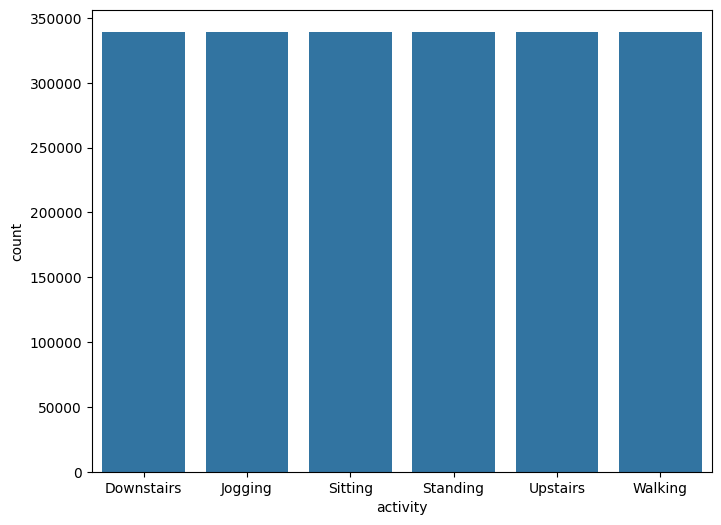

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "activity", data = df_train_balanced, order = df_train_balanced.activity.value_counts().index)
     

In [30]:
#############################################
# 4. PyTorch DataLoader 준비
#############################################
import torch
from torch.utils.data import DataLoader, TensorDataset

def prepare_loader(X, y, batch_size=64):
    # CNN 모델 입력은 (batch, channels, length) → 변환: (N, window_size, 3) → (N, 3, window_size)
    X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)
    # y는 정수형 라벨, shape (N,1) -> squeeze하여 (N,)
    y_tensor = torch.tensor(y, dtype=torch.long).squeeze()
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

train_loader = prepare_loader(X_train, y_train, batch_size=64)
val_loader = prepare_loader(X_val, y_val, batch_size=64)
test_loader = prepare_loader(X_test, y_test, batch_size=64)


In [27]:
#############################################
# 2. 시계열 데이터 세그먼테이션 함수 정의
#############################################
def create_dataset(X, y, time_steps=1, step=1):
    """
    X: 센서 데이터가 담긴 DataFrame (예: ["x_axis", "y_axis", "z_axis"])
    y: 라벨(인코딩된 값)이 담긴 Series (예: df["ActivityEncoded"])
    time_steps: 각 시퀀스(윈도우)의 길이 (예: 200)
    step: 윈도우 생성 시 이동 간격 (예: 40)
    """
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        # i부터 i+time_steps까지의 센서 데이터를 numpy 배열로 변환
        v = X.iloc[i:(i + time_steps)].values
        # 해당 구간의 라벨들을 선택하고, 다수결(mode)로 대표 라벨 결정
        window_labels = y.iloc[i:(i + time_steps)]
        mode_result = stats.mode(window_labels)
        mode_label = mode_result.mode
        # 만약 mode_label이 배열이면 첫 번째 원소 선택
        if isinstance(mode_label, np.ndarray):
            mode_label = mode_label[0]
        Xs.append(v)
        ys.append(mode_label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [28]:

#############################################
# 5. 간단한 1D CNN 분류기 정의
#############################################
import torch.nn as nn
import torch.optim as optim

# Device 설정 (MPS, CUDA 또는 CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple GPU)")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, window_size=200):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (window_size // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Using device: MPS (Apple GPU)


In [31]:
#############################################
# 6. 모델 학습 및 평가
#############################################
num_epochs = 10  # 학습 에폭 수
window_size=200
model = SimpleCNN(num_classes=num_classes, window_size=window_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("\n=== 모델 학습 시작 ===")
# 에폭별 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == y_batch)
        total_train += y_batch.size(0)
    
    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_corrects.float() / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc.item())
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    total_val = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_running_loss += loss.item() * X_val.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == y_val)
            total_val += y_val.size(0)
    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc = val_running_corrects.float() / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")



=== 모델 학습 시작 ===
Epoch 1/10, Train Loss: 0.2863, Train Acc: 0.8958, Val Loss: 0.0523, Val Acc: 0.9805
Epoch 2/10, Train Loss: 0.0496, Train Acc: 0.9825, Val Loss: 0.0356, Val Acc: 0.9869
Epoch 3/10, Train Loss: 0.0294, Train Acc: 0.9896, Val Loss: 0.0324, Val Acc: 0.9882
Epoch 4/10, Train Loss: 0.0224, Train Acc: 0.9919, Val Loss: 0.0317, Val Acc: 0.9888
Epoch 5/10, Train Loss: 0.0115, Train Acc: 0.9967, Val Loss: 0.0415, Val Acc: 0.9870
Epoch 6/10, Train Loss: 0.0102, Train Acc: 0.9963, Val Loss: 0.0767, Val Acc: 0.9781
Epoch 7/10, Train Loss: 0.0095, Train Acc: 0.9964, Val Loss: 0.0320, Val Acc: 0.9918
Epoch 8/10, Train Loss: 0.0168, Train Acc: 0.9952, Val Loss: 0.0366, Val Acc: 0.9912
Epoch 9/10, Train Loss: 0.0037, Train Acc: 0.9986, Val Loss: 0.0361, Val Acc: 0.9903
Epoch 10/10, Train Loss: 0.0076, Train Acc: 0.9975, Val Loss: 0.0395, Val Acc: 0.9889


In [32]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).squeeze()  # 만약 y_batch가 (batch_size, 1)이라면
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")

테스트 정확도: 98.82%


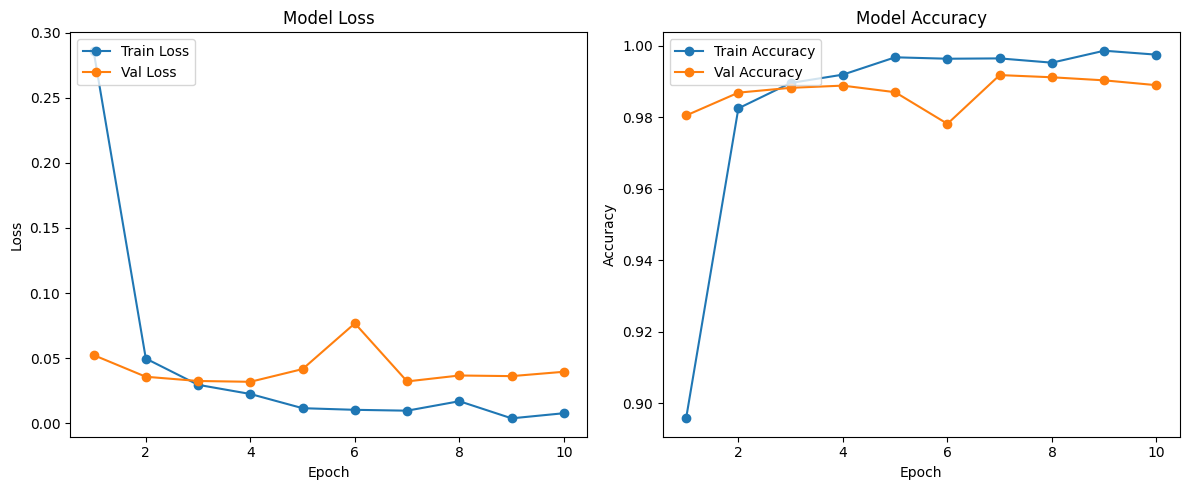

In [33]:
# 학습 및 검증 결과 플롯팅
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 손실 플롯
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# 정확도 플롯
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

F1 Score (weighted): 0.9882237879408649
Accuracy: 0.9882121807465619
Classification Report:
              precision    recall  f1-score   support

     Walking       0.97      0.97      0.97      1696
     Jogging       1.00      1.00      1.00      1697
    Upstairs       1.00      1.00      1.00      1697
  Downstairs       1.00      1.00      1.00      1697
     Sitting       0.96      0.97      0.97      1697
    Standing       0.99      0.99      0.99      1696

    accuracy                           0.99     10180
   macro avg       0.99      0.99      0.99     10180
weighted avg       0.99      0.99      0.99     10180



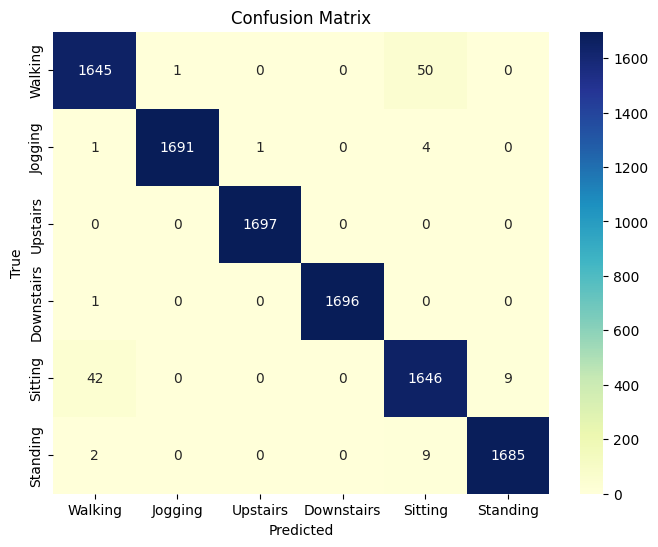

In [34]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# LABELS는 클래스 이름을 지정합니다.
LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

# 모델을 평가 모드로 전환
model.eval()

# 전체 test 데이터에 대해 예측값과 정답을 모읍니다.
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        # 각 샘플에 대해 가장 높은 확률을 가진 클래스 인덱스 선택
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(all_true, all_preds)

# 평가 지표 출력
print("F1 Score (weighted):", f1_score(all_true, all_preds, average='weighted'))
print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=LABELS))

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()